In this Notebook we will build an Ising Model representing counties of the continental USA and use ot to model the epidemic propagation.

In [1]:
import wget
import importlib
import time
import os
import numpy as np
import shapefile
import pandas as pd
from urllib.parse import urlparse
from collections import Counter

import geographical_map
importlib.reload(geographical_map)
GeographicalMap = geographical_map.GeographicalMap
import ising_model
importlib.reload(ising_model)
IsingModel = ising_model.IsingModel


def download_file(url):
    local_path = os.path.join('data', urlparse(url).path.split('/')[-1])
    if not os.path.exists(local_path):
        wget.download(url, local_path)
    return local_path

## Preparing the data

We want to build a graph in which vertices are USA counties. Two counties are connected by an adge if they are neighboring or if there is an regular flight between airports located in those counties.

### Geographical data
First, we read the map of the USA in the [Shapefile](https://en.wikipedia.org/wiki/Shapefile) format. We can get it, for example, from the Matplotlib repository. For each county we get its boundary as a polygon and its [FIPS](https://en.wikipedia.org/wiki/FIPS_county_code) code, which we will use as a county identifier.

Then we add an edge for all pairs of counties whose boundaries have at least 2 common corners. We call these "land edges". The graph we get at this point is planar.

### Population
For each county we get population from Census estimate for the year 2019. Data taken from [census.gov].

### Air links
First, we read all airports from [ourairports.com]. We leave only those airports which are located in the USA and have [IATA](https://en.wikipedia.org/wiki/IATA_airport_code) code. Then for each airport we check if it iis inside of one of counties. If so, we remeber relation between its IATA code and county FIPS code.

Then we get list of all regular flights from [https://openflights.org/], and leave only those for which source and destination airports are inside the USA. Then for each pair of counties connected by a flight we add an edge (unless they are already conencted by a land edge). We assign a weight to this edge equal to the number of flights connecting the counties. We will call these "air edges".

In [2]:
# Read county shapes.
shp_file = download_file('https://github.com/matplotlib/basemap/blob/master/lib/mpl_toolkits/basemap/data/UScounties.shp?raw=true')
dbf_file = download_file('https://github.com/matplotlib/basemap/blob/master/lib/mpl_toolkits/basemap/data/UScounties.dbf?raw=true')
sf = shapefile.Reader(shp_file, encoding = "ISO-8859-1")
shapes = sf.shapes()
records = sf.records()
fips_codes = []
polygons = []
for i in range(len(shapes)):
    state = records[i][3]
    if state == 'AK': continue 
    if state == 'HI': continue    
    if state == 'PR': continue        
    fips_code = records[i][2]
    fips_codes.append(fips_code)
    polygons.append(shapes[i].points)
usa_map = geographical_map.GeographicalMap(fips_codes, polygons)
print('Shapes OK.')
        
usa_map.calculate_land_edges()
print('Land edges OK.')

# Read county population.
url = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.csv"
population_data = pd.read_csv(download_file(url), encoding = "ISO-8859-1")
for _, row in population_data.iterrows():
    fips_code = "%.2d%.3d" % (row['STATE'], row['COUNTY'])
    if usa_map.has_region(fips_code):
        usa_map.set_population(fips_code, row['POPESTIMATE2019']) 
print('Population OK.')

# Read airports and determine in which county they are.
airport_data = pd.read_csv(download_file('https://ourairports.com/data/airports.csv'))
iata_to_fips = dict()
for _, row in airport_data.iterrows():
    if row['iso_country'] != 'US': continue
    iata_code = row['iata_code']
    if isinstance(iata_code, str):
        x = float(row['longitude_deg'])
        y = float(row['latitude_deg'])
        fips_code = usa_map.get_point_region(x, y)
        if fips_code is not None:
            iata_to_fips[iata_code] = fips_code
print('Airports read OK.')

# Read routes.
routes_file = download_file('https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat')
header = ['airline', 'airline_id', 'source_airport', 'source_airport_id',
          'dest_airport', 'dest_airport_id', 'codeshare', 'stops', 'equipment']
routes_data = pd.read_csv(routes_file, names=header)
# For each pair of counties calculate how many routes connect them.
ctr = Counter()
for _, row in routes_data.iterrows():
    iata1 = row['source_airport']
    iata2 = row['dest_airport']
    if iata1 in iata_to_fips and iata2 in iata_to_fips:
        fips1 = iata_to_fips[iata1]
        fips2 = iata_to_fips[iata2]
        if fips1 > fips2: fips1, fips2 = fips2, fips1
        ctr[(fips1, fips2)] += 1
# Add all air edges.
for fips1, fips2 in ctr:
    # Skip routes within the same county and between neighbor counties.
    if fips1 != fips2 and usa_map.get_edge(fips1, fips2) is None:
        usa_map.add_edge(fips1, fips2, 'air', ctr[(fips1, fips2)])
print('Air edges OK.')

Shapes OK.
Land edges OK.
Population OK.
Airports read OK.
Air edges OK.


Now let's see how many vertices and edges our graph has.

In [3]:
print("Regions: %d" % usa_map.region_ids.shape[0])
print("Edges: %d" % len(usa_map.edges))

Regions: 3109
Edges: 21878


To verify the data, let's show counties' population on the map.

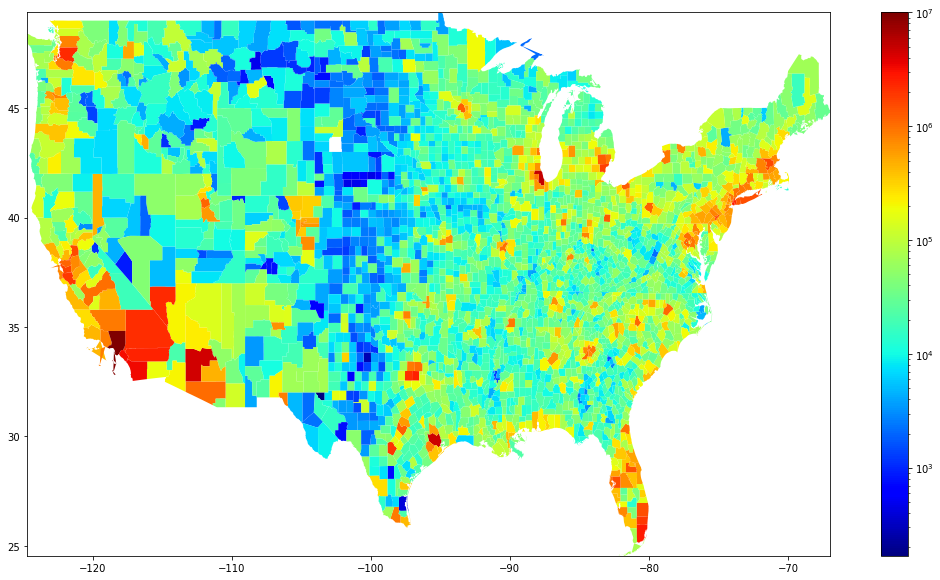

In [4]:
geographical_map.draw_map(usa_map, mode='population')

Now, let's show out graph on the map. Red are "land" edges, green are "air" edges.

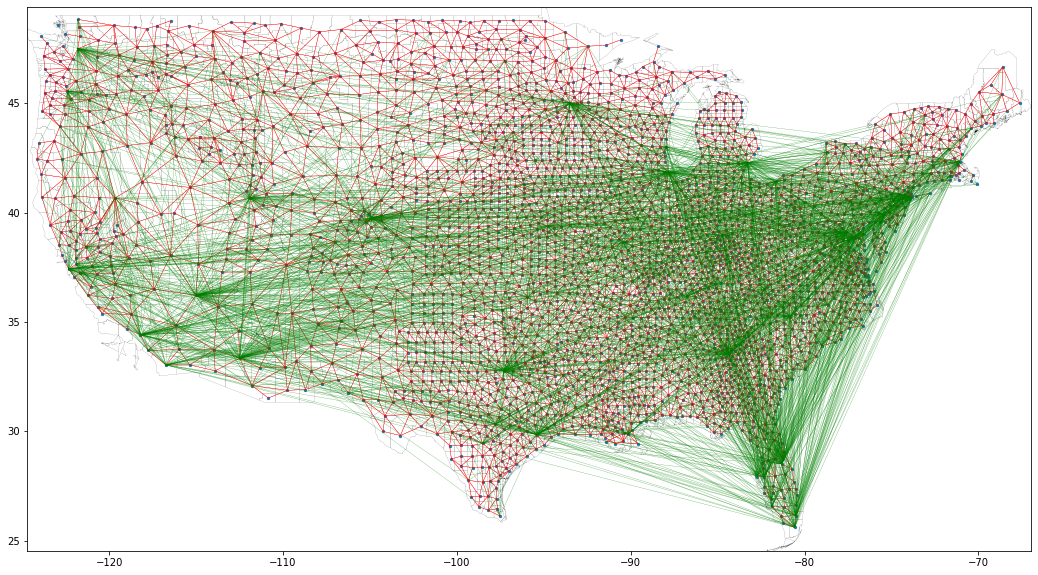

In [5]:
geographical_map.draw_map(usa_map, mode='graph')

## The Ising Model

### Definition

Formally, the Ising Model is a probability distribution of a random vector taking values $\{-1, +1\}^N$, where probablity of it having realization X is

$$\mathbb{P}(X) = Z^{-1} \exp(\mu^T X + X^T J X), $$

where 
$$Z = \sum_{X \in {\{\pm\} 1}^N} \exp(\mu^T X + \frac{1}{2} X^T J X)$$

ia a partition function, $\mu \in \mathbb{R}^N$ is vector of "fields", $J \in \mathbb{R}^{N \times N}$ is a matrix of "spin-spin interactions". $J$ is symmetric ($J^T = J$) and has zeroes on the diagonal.

### Ising Model for given graph

We want to build an Ising Model which would represent propagation of an epidemic in a country. "Spins" should correspond to counties, "fields" to some measure of county being susceptible to infection or being infected, "Spin-spin interactions" should correspond to some measure of infection propagation rate between the two counties. Value -1 corresponds to "not infected", +1 - to "infected".

Let's build the model in the following way:

* For county having population $p$, corresponding field is $-5 + \log_{10}(p)$.
* For "land" edge between counties $i$ and $j$, $J_{ij} = J_{ji} = k_{land} = 0.5$.
* For "air" edge between counties $i$ and $j$, if there are $f$ flights between them, $J_{ij} = J_{ji} = f \cdot k_{air}$, where $k_{air} = 0.2$.

### Monte-Carlo sampling

Let's do Monte-Carlo sampling. We will start with random vector $X \in \{\pm\} 1^N$ and repeat multiple times the following. Pick random index $i$ and consider probabilities of $X_i$ being equal to $ \sigma \in \{ \pm 1\}$, when all other spins are not changed.

$$\mathbb{P}(X_i = \sigma) = Z \cdot \exp \left(E_0 + \mu_{i} \sigma + \sum_{j} \sigma J_{ij} X_j \right) = Z \cdot e^{E_0} \cdot e^{k \sigma},$$

where $E_0$ is sum of all enery memebrs independednt of $X_i$, and $k = \mu_{i} + \sum_{j} \sigma J_{ij} X_j$.

Then

$$\mathbb{P}(X_i = -1) = \frac{e^{-k}}{e^{k} + e^{-k}} = \frac{1}{e^{2k} + 1}.$$ 

So, we set $X_i = -1$ with this probability.

### The experiment

Let's sample our Ising model 50 times and estimate marginal probability of county being infected $p_i = \mathbb{X_i = +1}$ by fraction of samples in which $X_i = +1$.

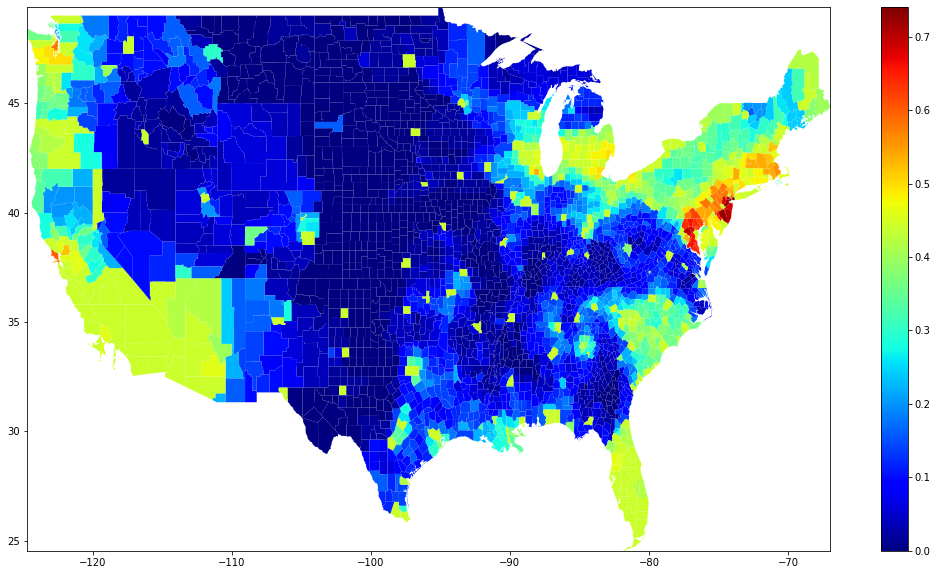

In [6]:
def to_ising_model(gmap, k_land=0.0, k_air=0.0):
    def to_ising_edge(edge):
        if edge.type == 'land':
            return edge.v1, edge.v2, k_land
        else:
            assert edge.type == 'air'
            return edge.v1, edge.v2, k_air * edge.value

    mu = -5 + np.log10(usa_map.population+1)
    interactions = [to_ising_edge(e) for e in usa_map.edges.values()]
    return IsingModel.create(mu, interactions)

model = to_ising_model(usa_map, k_land=0.5, k_air=0.2)
proba = model.marginal_proba_mc(num_samples=50)
geographical_map.draw_map(usa_map, mode='data', data=proba)